In [115]:
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import jieba
import re
from math import sqrt

### 把excel中的数据读入mongodb中

In [116]:
df = pd.read_excel('diary.xlsx')

In [117]:
client = pymongo.MongoClient('localhost',27017)
db = client.diary
column = db.diary
#每次重新插入数据库时，都要先清空
column.delete_many({})
for index in range(df.shape[0]):
    try:
        everyday = dict(df.iloc[index])
    #     del everyday['日期']
        column.insert_one(everyday)
    except:
        print(index)
        print(everyday['日期'])

### 从数据库中读出数据，把日记中的诸多信息分别赋值给多个变量供后面使用。

In [118]:
cursor = column.find()
cursor_new = cursor.clone()
keys = list(cursor_new[0].keys())
word_len = {}
text = ''
everyday_text = {}
everyday_item_text = {}
days = [] #存放所有日记的日期
for day in cursor_new:
    word_num = 0
    days.append(day['日期'])
    everyday_text[day['日期']] = ''
    everyday_item_text[day['日期']] = {}
    for key in keys:
        #统计是字符串的值，其他暂不能统计
        if key != '_id' and type(day[key]) == str:
            word_num += len(day[key])
            text += day[key]
            everyday_text[day['日期']] += day[key]
            everyday_item_text[day['日期']][key] = day[key]
    word_len[day['日期']] = word_num
# print(word_len)
# print(len(text))
# print(everyday_text['2020.3.28'])
print(everyday_item_text['2020.3.27']['警言'])

合抱之木，生于毫末；九层之台，起于累土；千里之行，始于足下。


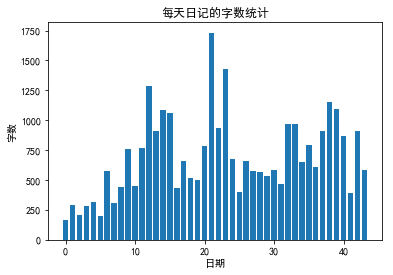

In [119]:
# list(word_len.keys())
# word_len.values
#正常显示中文
plt.rcParams["font.sans-serif"] = ["SimHei"]

plt.bar(range(len(word_len.keys())), word_len.values())
plt.xlabel("日期")
plt.ylabel('字数')
plt.title('每天日记的字数统计')
plt.show()

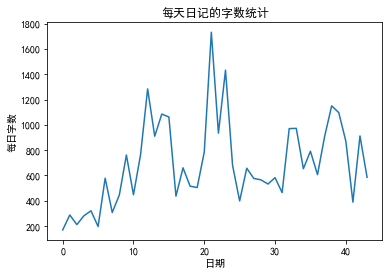

In [120]:
plt.plot(range(len(word_len.keys())), word_len.values())
plt.xlabel("日期")
plt.ylabel('每日字数')
plt.title('每天日记的字数统计')
plt.show()

### 每天字数增加进度折线
思路来源:
>得到APP，每天听本书，《暗时间》，提到进度条

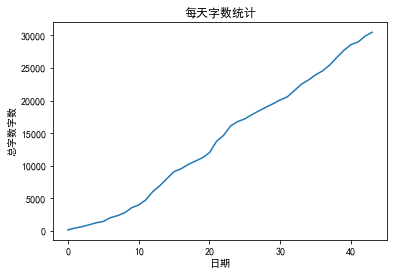

In [121]:
everyday_word_len = word_len.values()
increase_word_len = []
sum_len = 0
for each in everyday_word_len:
    sum_len += each
    increase_word_len.append(sum_len)
plt.plot(range(len(increase_word_len)), increase_word_len)
plt.xlabel("日期")
plt.ylabel('总字数字数')
plt.title('每天字数统计')
plt.show()

In [122]:
words = list(word_len.values())
word_sum = np.sum(words)
word_mean = np.mean(words)
word_median = np.median(words)
print('总字数：',word_sum,'\n','平均字数：',word_mean,'\n','字数中位数：',word_median)

总字数： 30461 
 平均字数： 692.2954545454545 
 字数中位数： 629.5


## 功能

### 1. 获得日记中的所有文本，并且分词

In [123]:
def jieba_depart(text):
    test_text = text
    test_text = re.sub(r'[^\u4e00-\u9fa5]+', '', test_text) #把非汉字的字符去掉
    word_depart = jieba.cut(test_text)
    words = list(word_depart)
    return words

words = jieba_depart(text)
# print(words)
# for word in words:
#     print(word)

### 2. 把列表中的单词统计词频

In [124]:

def get_word_num(word_list):
    word_num_dict = {}
    for word in word_list:
        if word not in word_num_dict:
            word_num_dict.setdefault(word,1)
        else:
            word_num_dict[word] += 1
    return word_num_dict

word_num_dict = get_word_num(words)

'''
plt.bar(range(len(word_num_dict.keys())), word_num_dict.values())
plt.xlabel("单词")
plt.ylabel('频率')
plt.title('日记词频统计')
plt.show()   
'''

'\nplt.bar(range(len(word_num_dict.keys())), word_num_dict.values())\nplt.xlabel("单词")\nplt.ylabel(\'频率\')\nplt.title(\'日记词频统计\')\nplt.show()   \n'

### 3. 根据词频排序

In [125]:
def word_num_sort(word_num_dict):
    word_num_tuple = zip(word_num_dict.values(), word_num_dict.keys())
    sort_word_num = sorted(word_num_tuple, reverse=True)
    return sort_word_num
sort_word_num = word_num_sort(word_num_dict)
# print(sort_word_num)

### 4. 选取指定范围的词，频率太高的，太低的都不太具有代表性

In [126]:
def select_word(sort_word_num, start=0.08, end=0.3):
    length = len(sort_word_num)
    start_index = int(length * start)
    end_index = int(length * end)
    represent = sort_word_num[start_index:end_index]
    return represent

# print(select_word(sort_word_num, 0.08, 0.13))

### 5. 获得任意一天的代表词频字典，类似于每个用户对物品的评价字典，构造数据集

In [127]:
critics = {}

for key,value in everyday_text.items():
    everyday_words = jieba_depart(value)
    everyday_word_num_sort = word_num_sort(get_word_num(everyday_words))
     
    word_num = select_word(everyday_word_num_sort)
    word_num_dict = {}
    for word in word_num:
        word_num_dict[word[1]] = word[0]
    critics[key] = word_num_dict

# print(critics)

### 6. 基于用户的协同过滤算法，推荐相似的一天。相似度量可选。

In [128]:
def sim_distance(prefs, person1, person2):
    si = {}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item] = 1

    if len(si) == 0:
        return 0

    sum_of_squares = sum([pow(prefs[person1][item]-prefs[person2][item],2) for item in prefs[person1] if item in prefs[person2]])

    # print(sum_of_squares)
    return 1/(1+sqrt(sum_of_squares))
def sim_pearson(prefs, p1, p2):
    si = {}
    for item in prefs[p1]:
        if item in prefs[p2]:
            si[item] = 1

    n = len(si)
#     print(n)
    if n == 0:
        return 0

    sum1 = sum([prefs[p1][it] for it in si])
    sum2 = sum([prefs[p2][it] for it in si])

    sum1Sq = sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq = sum([pow(prefs[p2][it],2) for it in si])

    pSum = sum([prefs[p1][it]*prefs[p2][it] for it in si])

    #计算皮尔逊评价值
    num = pSum - (sum1 * sum2 / n)
#     print(num)
    den = sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2, 2)/n))
#     print(den)
    if den == 0:
        return 0

    r = num / den

    return r

def topMatches(prefs, person, n=5, similarity=sim_pearson):
    scores=[(similarity(prefs,person,other), other) for other in prefs if other != person]
    scores.sort()
    scores.reverse()
    return scores[0:n]

def getRecommendations(prefs, person, similarity=sim_pearson):
    totals = {}
    simSums = {}
    for other in prefs:
    #不要和自己作比较
        if other == person:
            continue
        sim = similarity(prefs, person, other)

        #忽略评价值为零，或者小于零的情况
        if sim<=0:
            continue
        for item in prefs[other]:

          #只对自己还未看过的电影进行评价
          if item not in prefs[person] or prefs[person][item] == 0:
            #相似度*评价值
            totals.setdefault(item, 0)


### 7. 查看任意一天的所有日记信息

In [129]:
def look_everyday(date):
    return everyday_text[date]

In [147]:
# print(topMatches(critics,'2020.3.26'))
# print(look_everyday('2020.3.30'))

### 8. 显示任意一天任一个单项的日记

In [144]:
def diary_item(day, item):
    if item in everyday_item_text[day]:
        return everyday_item_text[day][item]
    else:
        return ''
print(diary_item('2020.2.16','警言'))

### 9. 显示任意一项的每天的日记

In [146]:
def item_everyday(days, item):
    for everyday in days:
        print(everyday,diary_item(everyday, item))
item_everyday(days, '警言')

2020.2.16 
2020.2.17 
2020.2.18 
2020.2.19 
2020.2.20 
2020.2.21 
2020.2.22 
2020.2.23 
2020.2.24 
2020.2.25 
2020.2.26 
2020.2.27 夫轻诺必寡信，多易必多难。是以圣人犹难之，故终无难矣。--《老子》
2020.2.28 静而后能安，安而后能虑，虑而后能得--《大学》
2020.2.29 图难于其易，为大于其细。天下难事，必作于易；天下大事，必作于细。--《老子》
2020.3.1 大道甚夷，而人好径。--《老子》
2020.3.2 知人者智，自知者明
2020.3.3 孰能浊以静之以清，孰能安以动之徐生。
2020.3.4 知足者富
2020.3.5 民之从事，常于几成而败之。慎终如始，则无败事。
2020.3.6 企者不立，跨者不行。
2020.3.7 以其终不自为大，故能成其大。
2020.3.8 为之于未有，治之于未乱。
2020.3.9 上士闻道，勤而行之；中士闻之，若存若忘；下士闻道，大笑之。不笑不足以为道。
2020.3.10 学不学，复众人之所过，以辅万物之自然而不敢为。
2020.3.11 致虚极，守静笃。
2020.3.12 夫物芸芸，各复归其根。归根曰静，静曰复命。复命曰常，知常曰明。不知常，妄作凶。
2020.3.13 为学日益，为道日损。
2020.3.14 少则得，多则惑。
2020.3.15 保此道者，不欲盈。夫唯不盈，故能敝而新成。
2020.3.16 光而不耀
2020.3.17 希言自然。
2020.3.18 大器晚成
2020.3.19 知其荣守其辱
2020.3.20 天地尚不能久，而况于人乎？
2020.3.21 凿户牖，当其无，有室之用。
2020.3.22 言有宗，事有君。
2020.3.23 知不知，尚矣；不知知，病也。
2020.3.24 知我者希，则我者贵。
2020.3.25 我有三宝，持而保之。一曰慈，二曰俭，三曰不敢为天下先。
2020.3.26 其脆易泮，其微易散。
2020.3.27 合抱之木，生于毫末；九层之台，起于累土；千里之行，始于足下。
2020.3.28 是以圣人方而不割
2020.3.29 道常无为而无不为
2020.3.30 祸莫大于不知足
